In [1]:
%matplotlib inline
import scipy.integrate as sp # For Numerical integration
import numpy as np
import random # for Cutpoint method
import matplotlib.pylab as plt
import scipy.interpolate as interpolate # For cubic interpolation
rng = np.random.RandomState() # seed of the random number generator

# Integrate the Function

In [2]:
class IntegralFunction:
    L = 76 # number of w2 values in the table
    N = 7000 # number of values for each integrated function
    w1 = 1./500. # fixed energy of soft photons
    r0 = 2.81794E-13 # classical electron radius
    intValues = np.zeros((L,2,N)) # stores epsilon and gamma values
    w2Values = np.zeros(L) # stores w2 values
    
    def getIntValues2(self,a,b):
        return self.intValues[a][b]
    def getW2Values(self,a):
        return self.w2Values[a]
    def getL(self):
        return self.L
    def getN(self):
        return self.N
    def getW1(self):
        return self.w1
    def getR0(self):
        return self.r0
    
    def integral(self,w2): # Computes the integrated functions
        def I(e):
            return np.pi*IntegralFunction.r0*IntegralFunction.r0/(4*IntegralFunction.w1*IntegralFunction.w1*w2**3)*(4*E**2/((E-e)*e)*np.log(4*IntegralFunction.w1*(E-e)*e/E)-8*IntegralFunction.w1*E+2*(2*IntegralFunction.w1*E-1)*E**2/((E-e)*e)-(1-1./(IntegralFunction.w1*E))*E**4/((E-e)**2*e**2))
        j = 0
        while(j < IntegralFunction.L):
            IntegralFunction.w2Values[j] = w2
            E = w2
            e = np.linspace(E/2.*(1-np.sqrt(1-1./(IntegralFunction.w1*E))), E/2.*(1+np.sqrt(1-1./(IntegralFunction.w1*E))),IntegralFunction.N)
            eMin = E/2.*(1-np.sqrt(1-1./(IntegralFunction.w1*E)))
            IArray = np.zeros(IntegralFunction.N) # to store values of the integrated function
            for i in range(IntegralFunction.N):
                IArray[i], err = sp.quad(I,eMin,e[i])
                e[i] /= e[-1]
                IntegralFunction.intValues[j][0][i] = e[i]
            for i in range(len(IArray)):
                IArray[i] /= IArray[-1]
                IntegralFunction.intValues[j][1][i] = IArray[i]
            w2 += 100.
            j += 1
            
        print "Success"
    

# Plot the Integrated Functions

In [3]:
def plotFunction(i,w2): # plots integrated functions
    i.integral(w2)
    for j in range(i.getL()):
        plt.plot(i.getIntValues2(j,0),i.getIntValues2(j,1))
    plt.xlabel('Epsilon/EpsilonMax')
    plt.ylabel('gamma')

# Binary Search the Table

In [4]:
class BiSearch: # search the table for the input w2 value
    index = 0
    isExact = 0
    def search(self, w2, L, w2Values): # takes your input value as an argument
        a = 0
        b = L - 1
        while ((b-a) > 1):
            if(w2 < w2Values[a] or w2Values[b] < w2): # input w2 is out of bounds
                print "Invalid, try again"
                BiSearch.isExact = -1
                break
            mid = int(float(b+a)/2.)
            if(w2 > w2Values[mid]): # value is higher than the midpoint
                a = mid # update the interval
                BiSearch.index = b
            elif(w2 < w2Values[mid]): # value is lower than the midpoint
                b = mid
                Bisearch.index = a
            else: # value is exactly that which is at the midpoint
                BiSearch.index = mid
                BiSearch.isExact = 1
                break
                
    def getIndex(self):
        return BiSearch.index
    def getIsExact(self):
        return self.isExact

# Interpolation

In [5]:
def interp(index, isExact, i, w, fArray):
    if(isExact == 0):
        l = i.getL() 
        intIndex = int(index)
        # Get specific points for interpolation from the table
        if(intIndex > l-4): # special case 1
            w2Values1 = i.getW2Values(l-4) # return w2 values
            w2Values2 = i.getW2Values(l-3)
            w2Values3 = i.getW2Values(l-2)
            w2Values4 = i.getW2Values(l-1)
            iValues1 = i.getIntValues2(l-4,1) # return gamma values
            iValues2 = i.getIntValues2(l-3,1)
            iValues3 = i.getIntValues2(l-2,1)
            iValues4 = i.getIntValues2(l-1,1)
        elif(intIndex < 3): # special case 2
            w2Values1 = i.getW2Values(0)
            w2Values2 = i.getW2Values(1)
            w2Values3 = i.getW2Values(2)
            w2Values4 = i.getW2Values(3)
            iValues1 = i.getIntValues2(0,1)
            iValues2 = i.getIntValues2(1,1)
            iValues3 = i.getIntValues2(2,1)
            iValues4 = i.getIntValues2(3,1)
        else:
            w2Values1 = i.getW2Values(intIndex-1)
            w2Values2 = i.getW2Values(intIndex)
            w2Values3 = i.getW2Values(intIndex+1)
            w2Values4 = i.getW2Values(intIndex+2)
            iValues1 = i.getIntValues2(intIndex-1,1)
            iValues2 = i.getIntValues2(intIndex,1)
            iValues3 = i.getIntValues2(intIndex+1,1)
            iValues4 = i.getIntValues2(intIndex+2,1)
        # Interpolate
        for x in range(i.getN()): # loop over epsilon
            wVal = np.array((w2Values1, w2Values2, w2Values3, w2Values4))
            iVal = np.array((iValues1[x], iValues2[x], iValues3[x], iValues4[x]))
            f = interpolate.interp1d(wVal,iVal,kind='cubic')
            fArray[x] = f(w) # store the interpolated values of the integrated function at w1
    elif(isExact == 1):
        print "Skipping cell, your w2 was in the table"

# Cutpoint Method

In [6]:
# Cutpoint method for a value of w2
def impCM(index, isExact, integ,c, fArray):
    intIndex = int(index)
    if(isExact == 0): # input w2 value was not from the table but within the bounds of it     
        eValues = integ.getIntValues2(intIndex,0) # return E/Emax array, the same for all w2, yields the interval a to b
        m = integ.getN() - 2 # number of total pointers
        p = np.zeros(m+1) # array of pointers
        for j in range(m): # compute the pointers, loop over 1 through m for pointers (0 to m-1 index)
            for a in range(1, integ.getN()):
                if(fArray[a] > (float(j)/m)):
                    p[j] = eValues[a] # assign the pointer
                    break # this was the first occurrence, and hence the miniumum since epsilon increases with index
        p[-1] = eValues[-1] # I_m+1 = b
        Z = np.zeros(integ.getN())
        for a in range(len(eValues)):
            U = rng.uniform(0,1,size=1)
            Lvalue = int(np.ceil(m*U))
            i = int(p[Lvalue])
            while(U > fArray[i]):
                i += 1
            Z[a] = eValues[i]
                
    elif(isExact == 1): # input w2 value was from the table
        eValues = integ.getIntValues2(intIndex,0) # return E/Emax
        iValues = integ.getIntValues2(intIndex,1) # return gamma
        m = len(eValues) - 2 # number of total pointers (minus j=m+1)
        p = np.zeros(m+1) # array of pointers
        # compute the pointers 
        for j in range(m): # loop over 0 though m-1 in the indices, 1 through m for pointers
            for a in range(1, len(iValues)):
                if(iValues[a]>(float(j)/m)): # IArray has the q_i values
                    p[j] = eValues[a]
                    break
        p[-1] = 1.0 # I_m+1 = b
        Z = np.zeros(len(eValues))
        for a in range(len(eValues)):
            U = rng.uniform(0,1,size=1) # random number between 0 and 1 from uniform distribution
            LValue = int(np.ceil(m*U))
            i = int(p[LValue])
            while(U > iValues[i]):
                i+=1
            Z[a] = eValues[i]

                
    # Histogram and function
    minimum = np.min(Z)
    maximum = np.max(Z)
    print minimum, maximum
    d, bins, patches = plt.hist(Z,70,normed=True,stacked=True, facecolor='r', alpha=1.0) # scales the variable in relative units
    
    # Plot the spectrum function
    E = c
    w = integ.getW1()
    r = integ.getR0()
    eArray = np.linspace(E/2.*(1-np.sqrt(1-1./(w*E))), E/2.*(1+np.sqrt(1-1./(w*E))),integ.getN())
    Spec = np.pi*r*r/(4*w*w*c**3)*(4*E**2/((E-eArray)*eArray)*np.log(4*w*(E-eArray)*eArray/E)-8*w*E+2*(2*w*E-1)*E**2/((E-eArray)*eArray)-(1-1./(w*E))*E**4/((E-eArray)**2*eArray**2))
    for i in range(integ.getN()):
        eArray[i] /= eArray[-1] # normalize epsilon values between 0 and 1
    plt.plot(eArray,Spec/np.trapz(Spec,x=eArray)) # divide by the integral
    
    plt.xlabel('Epsilon/Epsilon_Max')
    plt.ylabel('Normalized Frequency')
    plt.ylim(0)
    plt.title("Histogram from Cutpoint Method")

# int main()
# Computes the table and plot

Success


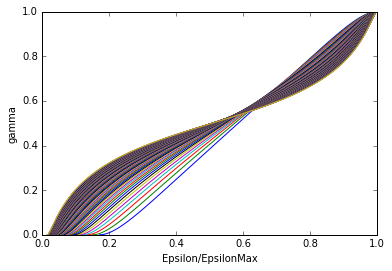

In [7]:
integ = IntegralFunction()
plotFunction(integ, 1000.) # initial w2 value is the second argument

# Uses an Input w2 Value and Cutpoint Method

0.01571784404 0.999015014283


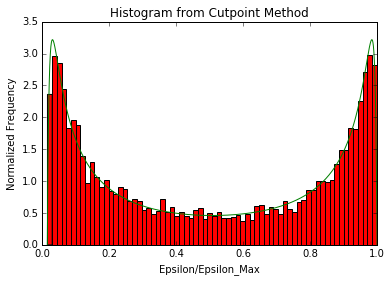

In [8]:
# Compute a histogram and estimate the probability density using an input w2 value
c = 8439. # The input value
fArray = np.zeros(integ.getN())
see = BiSearch()
w2Values = np.zeros(integ.getL())
for i in range(integ.getL()):
    w2Values[i] = integ.getW2Values(i)
see.search(c, integ.getL(), w2Values)
interp(see.getIndex(), see.getIsExact(), integ, c, fArray)
impCM(see.getIndex(), see.getIsExact(), integ, c, fArray)